[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/krasserm/bayesian-machine-learning/blob/master/gaussian_processes.ipynb)

In [1]:
try:
    # Check if notebook is running in Google Colab
    import google.colab
    # Get additional files from Github
    !wget https://raw.githubusercontent.com/krasserm/bayesian-machine-learning/master/gaussian_processes_util.py
    # Install additional dependencies
    !pip install GPy==1.9.8
except:
    pass

# Gaussian processes

## Introduction

In supervised learning, we often use parametric models $p(\mathbf{y} \lvert \mathbf{X},\boldsymbol\theta)$ to explain data and infer optimal values of parameter $\boldsymbol\theta$ via [maximum likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) or [maximum a posteriori](https://de.wikipedia.org/wiki/Maximum_a_posteriori) estimation. If needed we can also infer a full [posterior distribution](https://en.wikipedia.org/wiki/Posterior_probability) $p(\boldsymbol\theta \lvert \mathbf{X},\mathbf{y})$ instead of a point estimate $\boldsymbol{\hat\theta}$. With increasing data complexity, models with a higher number of parameters are usually needed to explain data reasonably well. Methods that use models with a fixed number of parameters are called parametric methods. 

In non-parametric methods, on the other hand, the number of parameters depend on the dataset size. For example, in [Nadaraya-Watson kernel regression](https://en.wikipedia.org/wiki/Kernel_regression), a weight $w_i$ is assigned to each observed target $y_i$ and for predicting the target value at a new point $\mathbf{x}$ a weighted average is computed: 

$$f(\mathbf{x}) = \sum_{i=1}^{N}w_i(\mathbf{x})y_i$$

$$w_i(\mathbf{x}) = \frac{\kappa(\mathbf{x}, \mathbf{x}_{i})}{\sum_{i'=1}^{N}\kappa(\mathbf{x}, \mathbf{x}_{i'})}$$

Observations that are closer to $\mathbf{x}$ have a higher weight than observations that are further away. Weights are computed from $\mathbf{x}$ and observed $\mathbf{x}_i$ with a kernel $\kappa$. A special case is k-nearest neighbors (KNN) where the $k$ closest observations have a weight $1/k$, and all others have weight $0$. Non-parametric methods often need to process all training data for prediction and are therefore slower at inference time than parametric methods. On the other hand, training is usually faster as non-parametric models only need to remember training data. 

Another example of non-parametric methods are [Gaussian processes](https://en.wikipedia.org/wiki/Gaussian_process) (GPs). Instead of inferring a distribution over the parameters of a parametric function Gaussian processes can be used to infer a distribution over functions directly. A Gaussian process defines a prior over functions. After having observed some function values it can be converted into a posterior over functions. Inference of continuous function values in this context is known as GP regression but GPs can also be used for classification. 

A Gaussian process is a [random process](https://en.wikipedia.org/wiki/Stochastic_process) where any point $\mathbf{x} \in \mathbb{R}^d$ is assigned a random variable $f(\mathbf{x})$ and where the joint distribution of a finite number of these variables $p(f(\mathbf{x}_1),...,f(\mathbf{x}_N))$ is itself Gaussian:

$$p(\mathbf{f} \lvert \mathbf{X}) = \mathcal{N}(\mathbf{f} \lvert \boldsymbol\mu, \mathbf{K})\tag{1}\label{eq1}$$

In Equation $(1)$, $\mathbf{f} = (f(\mathbf{x}_1),...,f(\mathbf{x}_N))$, $\boldsymbol\mu = (m(\mathbf{x}_1),...,m(\mathbf{x}_N))$ and $K_{ij} = \kappa(\mathbf{x}_i,\mathbf{x}_j)$. $m$ is the mean function and it is common to use $m(\mathbf{x}) = 0$ as GPs are flexible enough to model the mean arbitrarily well. $\kappa$ is a positive definite *kernel function* or *covariance function*. Thus, a Gaussian process is a distribution over functions whose shape (smoothness, ...) is defined by $\mathbf{K}$. If points $\mathbf{x}_i$ and $\mathbf{x}_j$ are considered to be similar by the kernel the function values at these points, $f(\mathbf{x}_i)$ and $f(\mathbf{x}_j)$, can be expected to be similar too. 

A GP prior $p(\mathbf{f} \lvert \mathbf{X})$ can be converted into a GP posterior $p(\mathbf{f} \lvert \mathbf{X},\mathbf{y})$ after having observed some data $\mathbf{y}$. The posterior can then be used to make predictions $\mathbf{f}_*$ given new input $\mathbf{X}_*$:

$$
\begin{align*}
p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{X},\mathbf{y}) 
&= \int{p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{f})p(\mathbf{f} \lvert \mathbf{X},\mathbf{y})}\ d\mathbf{f} \\ 
&= \mathcal{N}(\mathbf{f}_* \lvert \boldsymbol{\mu}_*, \boldsymbol{\Sigma}_*)\tag{2}\label{eq2}
\end{align*}
$$

Equation $(2)$ is the posterior predictive distribution which is also a Gaussian with mean $\boldsymbol{\mu}_*$ and $\boldsymbol{\Sigma}_*$. By definition of the GP, the joint distribution of observed data $\mathbf{y}$ and predictions $\mathbf{f}_*$  is

$$
\begin{pmatrix}\mathbf{y} \\ \mathbf{f}_*\end{pmatrix} \sim \mathcal{N}
\left(\boldsymbol{0},
\begin{pmatrix}\mathbf{K}_y & \mathbf{K}_* \\ \mathbf{K}_*^T & \mathbf{K}_{**}\end{pmatrix}
\right)\tag{3}\label{eq3}
$$

With $N$ training data and $N_*$ new input data, $\mathbf{K}_y = \kappa(\mathbf{X},\mathbf{X}) + \sigma_y^2\mathbf{I} = \mathbf{K} + \sigma_y^2\mathbf{I}$ is $N \times N$, $\mathbf{K}_* = \kappa(\mathbf{X},\mathbf{X}_*)$ is $N \times N_*$ and $\mathbf{K}_{**} = \kappa(\mathbf{X}_*,\mathbf{X}_*)$ is $N_* \times N_*$. $\sigma_y^2$ is the noise term in the diagonal of $\mathbf{K_y}$. It is set to zero if training targets are noise-free and to a value greater than zero if observations are noisy. The mean is set to $\boldsymbol{0}$ for notational simplicity. The sufficient statistics of the posterior predictive distribution, $\boldsymbol{\mu}_*$ and $\boldsymbol{\Sigma}_*$, can be computed with<sup>[1][3]</sup>

$$
\begin{align*}
\boldsymbol{\mu_*} &= \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{y}\tag{4}\label{eq4} \\
\boldsymbol{\Sigma_*} &= \mathbf{K}_{**} - \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{K}_*\tag{5}\label{eq5}
\end{align*}
$$

This is the minimum we need to know for implementing Gaussian processes and applying them to regression problems. For further details, please consult the literature in the [References](#References) section. The next section shows how to implement GPs with plain NumPy from scratch, later sections demonstrate how to use GP implementations from [scikit-learn](http://scikit-learn.org/stable/) and [GPy](http://sheffieldml.github.io/GPy/).

## Implementation with NumPy

Here, we will use the squared exponential kernel, also known as Gaussian kernel or RBF kernel:

$$
\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j))\tag{6}
$$

The length parameter $l$ controls the smoothness of the function and $\sigma_f$ the vertical variation. For simplicity, we use the same length parameter $l$ for all input dimensions (isotropic kernel). 

In [2]:
import numpy as np

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

There are many other kernels that can be used for Gaussian processes. See \[3\] for a detailed reference or the scikit-learn documentation for [some examples](http://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels).

### Prior

Let's first define a prior over functions with mean zero and a covariance matrix computed with kernel parameters $l=1$ and $\sigma_f=1$. To draw random functions from that GP we draw random samples from the corresponding multivariate normal. The following example draws three random samples and plots it together with the zero mean and the 95% confidence interval (computed from the diagonal of the covariance matrix).

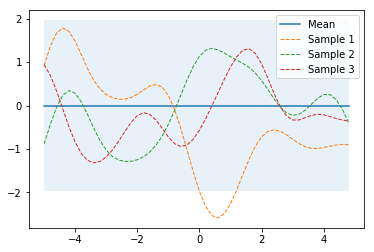

In [3]:
%matplotlib inline

from gaussian_processes_util import plot_gp

# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, confidence interval and samples 
plot_gp(mu, cov, X, samples=samples)

The `plot_gp` function is defined [here](gaussian_processes_util.py).

### Prediction from noise-free training data

To compute the sufficient statistics i.e. mean and covariance of the posterior predictive distribution we implement Equations $(4)$ and $(5)$

In [4]:
from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

and apply them to noise-free training data `X_train` and `Y_train`. The following example draws three samples from the posterior predictive and plots them along with the mean, confidence interval and training data. In a noise-free model, variance at the training points is zero and all random functions drawn from the posterior go through the trainig points. 

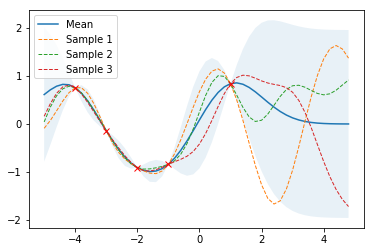

In [5]:
# Noise free training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

### Prediction from noisy training data

If some noise is included in the model, training points are only approximated and the variance at the training points is non-zero.

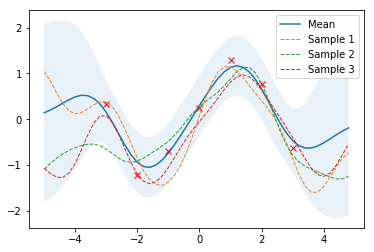

In [6]:
noise = 0.4

# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

### Effect of kernel parameters and noise parameter

The following example shows the effect of kernel parameters $l$ and $\sigma_f$ as well as the noise parameter $\sigma_y$. Higher $l$ values lead to smoother functions and therefore to coarser approximations of the training data. Lower $l$ values make functions more wiggly with wide confidence intervals between training data points. $\sigma_f$ controls the vertical variation of functions drawn from the GP. This can be seen by the wide confidence intervals outside the training data region in the right figure of the second row. $\sigma_y$ represents the amount of noise in the training data. Higher $\sigma_y$ values make more coarse approximations which avoids overfitting to noisy data.

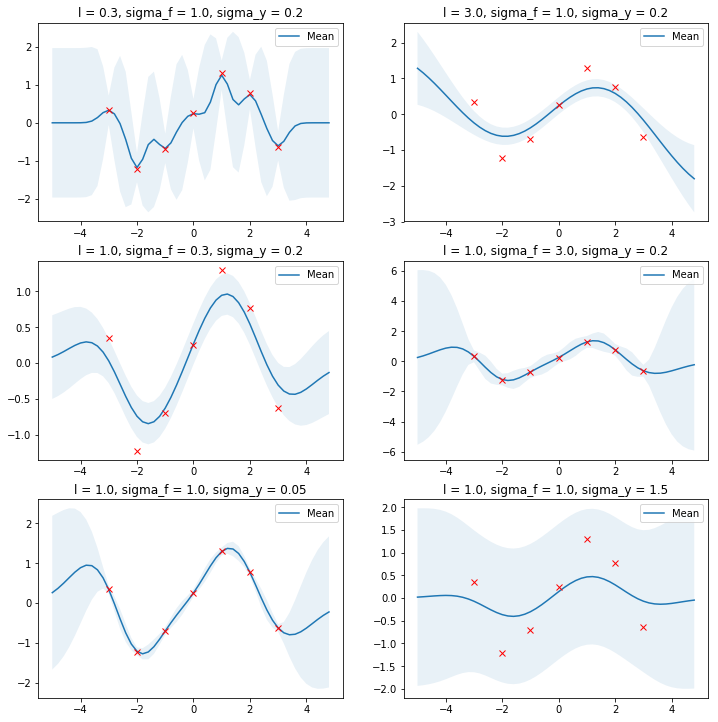

In [7]:
import matplotlib.pyplot as plt

params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

plt.figure(figsize=(12, 5))

for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l, 
                                       sigma_f=sigma_f, 
                                       sigma_y=sigma_y)
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

Optimal values for these parameters can be estimated by maximizing the log marginal likelihood which is given by<sup>[1][3]</sup>

$$
\log p(\mathbf{y} \lvert \mathbf{X}) = 
\log \mathcal{N}(\mathbf{y} \lvert \boldsymbol{0},\mathbf{K}_y) =
-\frac{1}{2} \mathbf{y}^T \mathbf{K}_y^{-1} \mathbf{y} 
-\frac{1}{2} \log \begin{vmatrix}\mathbf{K}_y\end{vmatrix} 
-\frac{N}{2} \log(2\pi) \tag{7}
$$

In the following we will minimize the negative log marginal likelihood w.r.t. parameters $l$ and $\sigma_f$, $\sigma_y$ is set to the known noise level of the data. If the noise level is unknown, $\sigma_y$ can be estimated as well along with the other parameters. 

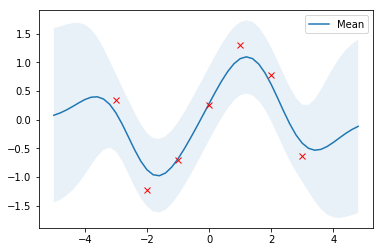

In [8]:
from numpy.linalg import cholesky, det, lstsq
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, noise, naive=True):
    '''
    Returns a function that computes the negative log marginal
    likelihood for training data X_train and Y_train and given 
    noise level.
    
    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        naive: if True use a naive implementation of Eq. (7), if 
               False use a numerically more stable implementation. 
        
    Returns:
        Minimization objective.
    '''
    def nll_naive(theta):
        # Naive implementation of Eq. (7). Works well for the examples 
        # in this article but is numerically less stable compared to 
        # the implementation in nll_stable below.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        return 0.5 * np.log(det(K)) + \
               0.5 * Y_train.T.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    def nll_stable(theta):
        # Numerically more stable implementation of Eq. (7) as described
        # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
        # 2.2, Algorithm 2.1.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        L = cholesky(K)
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.T.dot(lstsq(L.T, lstsq(L, Y_train)[0])[0]) + \
               0.5 * len(X_train) * np.log(2*np.pi)
    
    if naive:
        return nll_naive
    else:
        return nll_stable

# Minimize the negative log-likelihood w.r.t. parameters l and sigma_f.
# We should actually run the minimization several times with different
# initializations to avoid local minima but this is skipped here for
# simplicity.
res = minimize(nll_fn(X_train, Y_train, noise), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

# Store the optimization results in global variables so that we can
# compare it later with the results from other implementations.
l_opt, sigma_f_opt = res.x
l_opt, sigma_f_opt

# Compute the prosterior predictive statistics with optimized kernel parameters and plot the results
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l_opt, sigma_f=sigma_f_opt, sigma_y=noise)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

With optimized kernel parameters, training data are reasonably covered by the 95% confidence interval and the mean of the posterior predictive is a good approximation.

### Higher dimensions

The above implementation can also be used for higher input data dimensions. Here, a GP is used to fit noisy samples from a sine wave originating at $\boldsymbol{0}$ and expanding in the x-y plane. The following plots show the noisy samples and the posterior predictive mean before and after kernel parameter optimization.

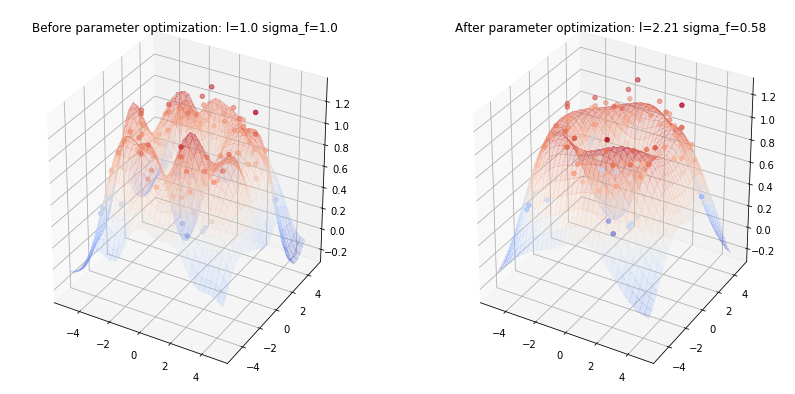

In [9]:
from gaussian_processes_util import plot_gp_2D

noise_2D = 0.1

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2D = np.c_[gx.ravel(), gy.ravel()]

X_2D_train = np.random.uniform(-4, 4, (100, 2))
Y_2D_train = np.sin(0.5 * np.linalg.norm(X_2D_train, axis=1)) + \
             noise_2D * np.random.randn(len(X_2D_train))

plt.figure(figsize=(14,7))

mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train, 
           f'Before parameter optimization: l={1.00} sigma_f={1.00}', 1)

res = minimize(nll_fn(X_2D_train, Y_2D_train, noise_2D), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, *res.x, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train,
           f'After parameter optimization: l={res.x[0]:.2f} sigma_f={res.x[1]:.2f}', 2)

Note how the true sine wave is approximated much better after parameter optimization.

## Libraries that implement GPs

This section shows two examples of libraries that provide implementations of GPs. I'll provide only a minimal setup here, just enough for reproducing the above results. For further details please consult the documentation of these libraries.

### Scikit-learn

Scikit-learn provides a `GaussianProcessRegressor` for implementing [GP regression models](http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-regression-gpr). It can be configured with [pre-defined kernels and user-defined kernels](http://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels). Kernels can also be composed. The squared exponential kernel is the `RBF` kernel in scikit-learn. The `RBF` kernel only has a `length_scale` parameter which corresponds to the $l$ parameter above. To have a $\sigma_f$ parameter as well, we have to compose the `RBF` kernel with a `ConstantKernel`.

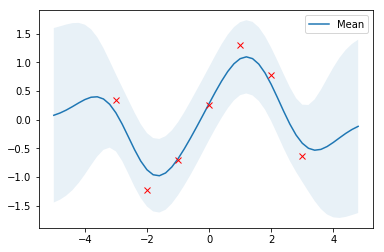

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2)

# Reuse training data from previous 1D example
gpr.fit(X_train, Y_train)

# Compute posterior predictive mean and covariance
mu_s, cov_s = gpr.predict(X, return_cov=True)

# Obtain optimized kernel parameters
l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])

# Compare with previous results
assert(np.isclose(l_opt, l))
assert(np.isclose(sigma_f_opt, sigma_f))

# Plot the results
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

### GPy

[GPy](http://sheffieldml.github.io/GPy/) is a Gaussian processes framework from the Sheffield machine learning group. It provides a `GPRegression` class for implementing GP regression models. By default, `GPRegression` also estimates the noise parameter $\sigma_y$ from data, so we have to `fix()` this parameter to be able to reproduce the above results.

In [11]:
import GPy

rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
gpr = GPy.models.GPRegression(X_train, Y_train, rbf)

# Fix the noise variance to known value 
gpr.Gaussian_noise.variance = noise**2
gpr.Gaussian_noise.variance.fix()

# Run optimization
gpr.optimize();

# Display optimized parameter values
display(gpr)

GP_regression.,value,constraints,priors
rbf.variance,0.6078930786683978,+ve,
rbf.lengthscale,0.9242513823591277,+ve,
Gaussian_noise.variance,0.16000000000000003,+ve fixed,


 /home/martin/miniconda3/envs/ml/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


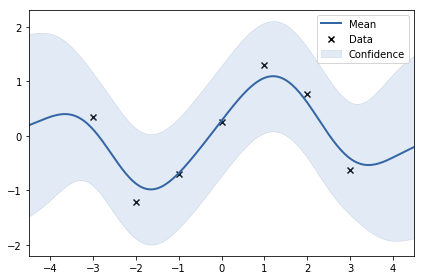

In [12]:
# Obtain optimized kernel parameters
l = gpr.rbf.lengthscale.values[0]
sigma_f = np.sqrt(gpr.rbf.variance.values[0])

# Compare with previous results
assert(np.isclose(l_opt, l))
assert(np.isclose(sigma_f_opt, sigma_f))

# Plot the results with the built-in plot function
gpr.plot();

Thanks for reading up to here :-) In another article, I'll show how Gaussian processes can be used for black-box optimization.

## References

\[1\] Kevin P. Murphy. [Machine Learning, A Probabilistic Perspective](https://mitpress.mit.edu/books/machine-learning-0), Chapters 4, 14 and 15.  
\[2\] Christopher M. Bishop. [Pattern Recognition and Machine Learning](http://www.springer.com/de/book/9780387310732), Chapter 6.  
\[3\] Carl Edward Rasmussen and Christopher K. I. Williams. [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/).  